## Random Lake Environment

In [1]:
# HIDDEN
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['font.size'] = 14

#### Learning a policy

- Let's train an agent to complete the Frozen Pond using RLlib.
- This is similar to our Frozen Lake agent from Module 1.

#### Quick aside: default config

- For brevity, we'll introduce the following default trainer config settings:

In [2]:
lake_default_config = {
    "framework"             : "torch",
    "create_env_on_driver"  : True,
    "seed"                  : 0,
    "horizon"               : 100,
    "model"                 : {"fcnet_hiddens" : [32, 32]}}

So, if you see `lake_default_config`, this is what it contains!

#### Learning a policy

- Back to it: let's train an agent to complete the Frozen Pond using RLlib.
- This is similar to our Frozen Lake agent from Module 1.

In [24]:
from ray.rllib.agents.ppo import PPOTrainer
from gym.wrappers import TimeLimit
from envs import FrozenPond # defined in previous slides

In [25]:
trainer = PPOTrainer(lake_default_config, env=FrozenPond)

In [26]:
train_info = trainer.train()

#### Learning a policy

We see that the agent only reaches the goal in ~2% of evaluation episodes.

In [27]:
trainer.evaluate()["evaluation"]["episode_reward_mean"]

0.021897810218978103

We can improve the agent by training for more iterations.

#### Learning a policy

In [28]:
for i in range(8):
    trainer.train()

In [29]:
trainer.evaluate()["evaluation"]["episode_reward_mean"]

0.9612903225806452

With another 8 training iterations, we increased the success rate to more than 96%. Nice.

#### Beyond the simple environment

We just trained an agent to learn this fixed Frozen Pond:

In [9]:
pond = FrozenPond()
pond.reset()
pond.render()

P...
.O.O
...O
O..G


But this is quite an easy problem:

- Small state space
- Small action space
- No stochasticity

#### Random lake

- Let's make the problem harder by looking at a _random_ frozen lake
- That is, the hole locations change every episode.
- We'll do this by reimplementing the `reset` method:

In [10]:
class RandomLake(FrozenPond):
    def reset(self):
        self.player = (0, 0) # the player starts at the top-left
        self.goal = (3, 3)   # goal is at the bottom-right
        
        self.holes = np.random.rand(4, 4) < 0.2
        self.holes[self.player] = 0  # no hole at start location
        self.holes[self.goal] = 0    # no hole at goal location
        
        return 0 # the observation corresponding to (0,0)

Now, each square (except the start and end locations) is a hole with probability 20%

#### Random lake

Here's one random lake:

In [11]:
# HIDDEN
np.random.seed(2)

In [12]:
lake = RandomLake()
lake.reset()
lake.render()

PO..
....
....
O.OG


Here's another:

In [13]:
# HIDDEN
np.random.seed(3)

In [14]:
lake.reset()
lake.render()

P...
..O.
O.O.
...G


#### Impossible games

And here's one more:

In [15]:
# HIDDEN
np.random.seed(1)

In [16]:
lake.reset()
lake.render()

P.O.
OOO.
....
..OG


- This time, there is no way to the goal! 
- This is a situation where the maximum episode length would really come in handle.
  - We saw this earlier with the gym `TimeLimit` wrapper.
- With these impossible lakes, we should no longer be aiming for a 100% win rate.

#### Learning the random lake

- We've had success with RLlib so far, achieving a decent win rate on the original Frozen Lake.
- Let's try the random lake:

In [17]:
trainer = PPOTrainer(lake_default_config, env=RandomLake)

In [18]:
train_info = trainer.train()

In [19]:
trainer.evaluate()["evaluation"]["episode_reward_mean"]

0.15337423312883436

This looks good for only one training iteration.

#### Learning the random lake

Let's try more iterations:

In [20]:
for i in range(4):
    train_info = trainer.train()

In [21]:
trainer.evaluate()["evaluation"]["episode_reward_mean"]

0.35331230283911674

Yikes. Another 4 iterations?

In [22]:
for i in range(4):
    train_info = trainer.train()

In [23]:
trainer.evaluate()["evaluation"]["episode_reward_mean"]

0.328537170263789

#### Comparing environments

- It looks like we're hitting a plateau here and falling into the lake most of the time.
- Let's compare the learning curves of the two environments:

In [30]:
fixed_trainer = PPOTrainer(lake_default_config, env=FrozenPond)
rando_trainer = PPOTrainer(lake_default_config, env=RandomLake)
fixed_rewards = []
rando_rewards = []

for i in range(8):
    fixed_rewards.append(fixed_trainer.train()['episode_reward_mean'])
    rando_rewards.append(rando_trainer.train()['episode_reward_mean'])

#### Comparing environments

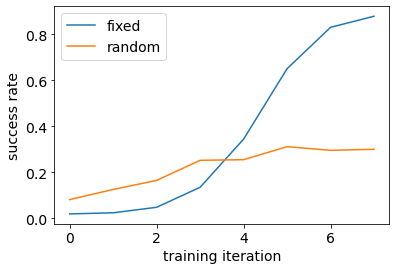

In [31]:
plt.plot(fixed_rewards, label="fixed")
plt.plot(rando_rewards, label="random")
plt.xlabel("training iteration")
plt.ylabel("success rate")
plt.legend();

This confirms our idea that the random lake environment is much harder to solve.

#### Random lake challenges

- So, why is the random lake so hard?
- Recall what we're learning: a policy, which maps observations to actions.
- Here, our observations are the location in the lake, and the action is the movement direction.
- So, say the observation is 3, meaning you're standing at the top-right. What action should you take?
- Answer: it depends on where the holes are!
- We're asking our agent to avoid holes _without being able to see_.
- In the next section we'll address this issue.

#### Let's apply what we learned!

## Number of holes
<!-- multiple choice -->

Our Random Lake environment is set up so that each square (except the start and goal) has a 20% probability of being a hole. 

#### Average episode reward

What do you think would happen to the average episode **reward** if we increased this number to 50%?

- [ ] The average episode reward would increase.
- [x] The average episode reward would decrease.

#### Average episode length

What do you think would happen to the average episode **length** if we increased this number to 50%?

- [ ] The average episode length would increase.
- [x] The average episode length would decrease.

## Where is the randomness?
<!-- multiple choice -->

In our implementation of `RandomLake`, we put the random hole creation in the `reset` method:

```python
self.holes = np.random.rand(4, 4) < 0.2
```

What would have happened if we put this in the constructor instead?

- [ ] It would behave the same as the current implementation.
- [ ] It would revert back to the non-random Frozen Pond from the previous module.
- [x] The holes would be randomized each time an environment is created, but all episodes would have the same random holes.

## Step counter
<!-- multiple choice -->

Let's say we wanted to implement a step counter in our environment _manually_, not using gym's `TimeLimit` wrapper or RLlib's `"horizon"` parameter for training. As a reminder, we would like the episodes to end after 50 steps even if you haven't reached the goal or fallen into a hole. 

#### Initializing the counter variable

First, we would need to created a new counter variable, say `self.stepcount`, and initialize it to zero with `self.stepcount = 0`. In which method would we include this code?

- [ ] constructor
- [x] `reset`
- [ ] `step`
- [ ] `done` (called by `step`)
- [ ] `render`

#### Incrementing the counter

Next, we would need to increment this counter after each step, say with `self.stepcount += 1`. In which method would we include this code?

- [ ] constructor
- [ ] `reset`
- [x] `step`
- [ ] `done` (called by `step`)
- [ ] `render`

#### Ending the episode

Finally, we would need to make sure the episode ends if the `self.stepcount >= 50`. Which method should we modify?

- [ ] constructor
- [ ] `reset`
- [ ] `step`
- [x] `done` (called by `step`)
- [ ] `render`

## Step counter: implementation
<!-- coding exercise -->

Below is the code of the Random Lake (minus rendering). Following the logic from the previous exercise, implement a step counter so that the max episode length is 50 steps. Then, test it out with the provided code, which repeatedly moves left (thus not moving at all).

In [ ]:
# EXERCISE

import gym

class RandomLake(gym.Env):
    def __init__(self, env_config=None):
        self.observation_space = gym.spaces.Discrete(16)
        self.action_space = gym.spaces.Discrete(4)      
        
    def reset(self):
        self.player = (0, 0) # the player starts at the top-left
        self.goal = (3, 3)   # goal is at the bottom-right
        
        self.holes = np.random.rand(4, 4) < 0.2
        self.holes[self.player] = 0  # no hole at start location
        self.holes[self.goal] = 0    # no hole at goal location
        
        return self.observation()
    
    def observation(self):
        return 4*self.player[0] + self.player[1]
    
    def reward(self):
        return int(self.player == self.goal)
    
    def done(self):
        is_done = self.player == self.goal or self.holes[self.player] == 1 
        return is_done
    
    def is_valid_loc(self, location):
        return 0 <= location[0] <= 3 and 0 <= location[1] <= 3

    def step(self, action):
        # Compute the new player location
        if action == 0:   # left
            new_loc = (self.player[0], self.player[1]-1)
        elif action == 1: # down
            new_loc = (self.player[0]+1, self.player[1])
        elif action == 2: # right
            new_loc = (self.player[0], self.player[1]+1)
        elif action == 3: # up
            new_loc = (self.player[0]-1, self.player[1])
        else:
            raise ValueError("Action must be in {0,1,2,3}")
        
        # Update the player location only if you stayed in bounds
        if self.is_valid_loc(new_loc):
            self.player = new_loc
            
        self.stepcount += 1
        
        return self.observation(), self.reward(), self.done(), {}
    
lake = RandomLake()
obs = lake.reset()

done = False
for i in range(55):
    obs, rewards, done, _ = lake.step(0)
    print(i+1, done)

In [ ]:
# SOLUTION

import gym

class RandomLake(gym.Env):
    def __init__(self, env_config=None):
        self.observation_space = gym.spaces.Discrete(16)
        self.action_space = gym.spaces.Discrete(4)      
        
    def reset(self):
        self.player = (0, 0) # the player starts at the top-left
        self.goal = (3, 3)   # goal is at the bottom-right
        
        self.holes = np.random.rand(4, 4) < 0.2
        self.holes[self.player] = 0  # no hole at start location
        self.holes[self.goal] = 0    # no hole at goal location
        
        self.stepcount = 0
        
        return self.observation()
    
    def observation(self):
        return 4*self.player[0] + self.player[1]
    
    def reward(self):
        return int(self.player == self.goal)
    
    def done(self):
        is_done = self.player == self.goal or self.holes[self.player] == 1 or self.stepcount >= 50
        return is_done
    
    def is_valid_loc(self, location):
        return 0 <= location[0] <= 3 and 0 <= location[1] <= 3

    def step(self, action):
        # Compute the new player location
        if action == 0:   # left
            new_loc = (self.player[0], self.player[1]-1)
        elif action == 1: # down
            new_loc = (self.player[0]+1, self.player[1])
        elif action == 2: # right
            new_loc = (self.player[0], self.player[1]+1)
        elif action == 3: # up
            new_loc = (self.player[0]-1, self.player[1])
        else:
            raise ValueError("Action must be in {0,1,2,3}")
        
        # Update the player location only if you stayed in bounds
        if self.is_valid_loc(new_loc):
            self.player = new_loc
            
        self.stepcount += 1
        
        return self.observation(), self.reward(), self.done(), {}
    
lake = RandomLake()
obs = lake.reset()

done = False
for i in range(55):
    obs, rewards, done, _ = lake.step(0)
    print(i+1, done)